In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import pickle
from functools import reduce
from dateutil.relativedelta import *

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [2]:
from helpers import load, plot, analyse

In [3]:
plot.ERC_Management().set_plot_params()
fig_width = 6.33

In [4]:
## Load data
start_date = '2023-03-04 01:00:00' #gut um nans zu zeigen
end_date = '2023-03-22 02:05:00'
data = load.load_raw_data(start_date, end_date, masked=True)

In [10]:
misfit_dict_in, medians_in = analyse.get_vault_outliers_median_filter(data, after='_T_in', threshold=0.12)
misfit_dict_out, medians_out = analyse.get_vault_outliers_median_filter(data, after='_T_out', threshold=0.24)

In [11]:
filtered_data = data
colors = ['#89CFF0','#A52A2A', '#AFE1AF']

param_csv = pd.read_csv('Supplementary_BHE_Data.csv')
colordict = plot.get_colordict()

In [12]:
data_summary = pd.DataFrame()
data_summary.index = data.index 
m = plot.ERC_Management()
west_out, south_out, east_out = m.generate_ID_strings_per_shaft(after='_T_out')
west_in, south_in, east_in = m.generate_ID_strings_per_shaft(after='_T_in')
for wrong in misfit_dict_in.keys():
    if wrong in south_in:
        south_in.remove(wrong)
    if wrong in west_in:
        west_in.remove(wrong)
    if wrong in east_in:
        east_in.remove(wrong)

data_summary['west_in_T'] = filtered_data[west_in].mean(axis=1)
data_summary['west_in_sd'] = filtered_data[west_in].std(axis=1)
data_summary['south_in_T'] = filtered_data[south_in].mean(axis=1)
data_summary['south_in_sd'] = filtered_data[south_in].std(axis=1)
data_summary['east_in_T'] = filtered_data[east_in].mean(axis=1)
data_summary['east_in_sd'] = filtered_data[east_in].std(axis=1)

In [13]:
west, south, east = m.generate_ID_strings_per_shaft(before='', after='')
westdT, southdT, eastdT = m.generate_ID_strings_per_shaft(before='dT_', after='')
for probe in range(1,41):
    probe = f'{probe:02d}'
    if probe in west:
        data_summary[f'dT_{probe}'] = data_summary['west_in_T']-data[f'Probe_{probe}_T_out']
    if probe in south:
        data_summary[f'dT_{probe}'] = data_summary['south_in_T']-data[f'Probe_{probe}_T_out']
    if probe in east:
        data_summary[f'dT_{probe}'] = data_summary['east_in_T']-data[f'Probe_{probe}_T_out']
data_summary['dT_west'] = data_summary[westdT].mean(axis=1)
data_summary['dT_sd_west'] = data_summary[westdT].std(axis=1)
data_summary['dT_south'] = data_summary[southdT].mean(axis=1)
data_summary['dT_sd_south'] = data_summary[southdT].std(axis=1)
data_summary['dT_east'] = data_summary[eastdT].mean(axis=1)
data_summary['dT_sd_east'] = data_summary[eastdT].std(axis=1)

C:\Users\Elisa\AppData\Local\Temp\ipykernel_22744\3127997497.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['29', '91', '117'])


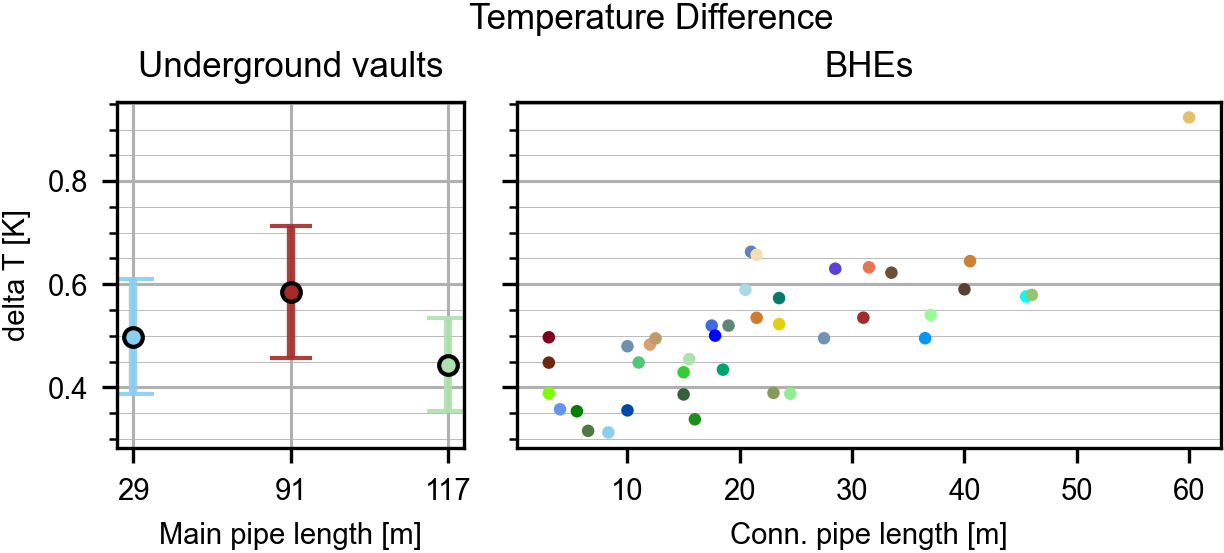

In [16]:
fig, ax = plt.subplots(1,2,figsize=(fig_width*0.75, 1.5), dpi=300, sharey=True, width_ratios=(0.33, 0.67))
fig.suptitle('Temperature Difference', y=1.1)

stat = data_summary.describe()

y = stat.loc['mean', ['dT_west', 'dT_south', 'dT_east']].values
x = ['West', 'South', 'East']
yerr = stat.loc['mean', ['dT_sd_west', 'dT_sd_south', 'dT_sd_east']].values

for i in range(len(y)):
    ax[0].errorbar(x[i], y[i], yerr=yerr[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[0].scatter(x[i], y[i], facecolor=colors[i], edgecolor='k', zorder=100, s=20)

#ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels(['29', '91', '117'])

ax[0].set_title('Underground vaults')
ax[0].set_ylabel('delta T [K]')
ax[0].set_xlabel('Main pipe length [m]')
ax[0].grid(which='minor', linewidth=.2)
ax[0].grid(which='major', linewidth=.75)

ax[1].scatter(param_csv['Pipelength'], stat.filter(regex='dT_[0-9]').loc['mean'], color=list(colordict.values()), s=4, zorder=11)
ax[1].set_title('BHEs')
ax[1].set_xlabel('Conn. pipe length [m]')
ax[1].grid(which='minor', linewidth=.2, axis='y')
ax[1].grid(which='major', linewidth=.75, axis='y')

fig.subplots_adjust(wspace=0.1)

plt.savefig('Validate_deltaT.pdf', dpi=300, bbox_inches='tight')